# Does "Buying the Dip" Truly Work?

### Overview


Today, we're going to be observing historical data of the S&P 500 while observing and executing trades based on the Close and Low differential, and then measuring the probability that the next day is an upwards move. All in all, this leads us to get a better idea of how efficient following a long term strategy of "buying the dip" truly is.

### Preparation


We begin by importing the necessary Python libraries, and setting up the range we will work between.


In [20]:
import yfinance as yf
import datetime
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [21]:
SYMBOL = "^GSPC"
PCT_THRESH = 20

START = datetime.datetime(2000, 1, 1)
END = datetime.datetime(2024, 1, 1)
YEARS = (END - START).days / 365.25

### Preparing Data


Using `yfinance`, we download historical price data for the S&P 500. 
We then clean the data by removing redundant columns, which are not needed for our analysis.


In [22]:
price = yf.download(SYMBOL, start=START, end=END)
price = price.drop(['Volume', 'Adj Close'], axis=1)
price.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close
Date,,,,
2023-12-22,4753.919922,4772.939941,4736.770020,4754.629883
2023-12-26,4758.859863,4784.720215,4758.450195,4774.750000
2023-12-27,4773.450195,4785.390137,4768.899902,4781.580078
2023-12-28,4786.439941,4793.299805,4780.979980,4783.350098
2023-12-29,4782.879883,4788.430176,4751.990234,4769.830078


### Data Visualization


Visualizing the closing prices of the S&P 500 over time can properly provide us with a better understanding of the market trends and fluctuations. 


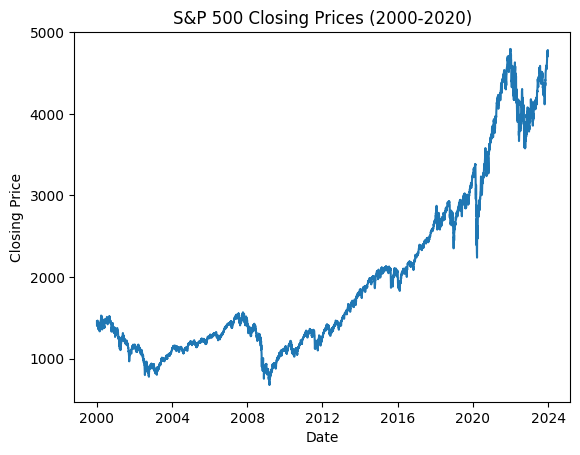

In [23]:

plt.plot(price.Close)
plt.title('S&P 500 Closing Prices (2000-2020)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()
    

Calculating Key Metrics


Here, we calculate several key metrics that will form the basis of our trading strategy:
- **Return**: The daily return of the S&P 500.
- **Range**: The daily price range (High - Low).
- **Dist**: The distance of the closing price from the low of the day.
- **Pct**: The percentage of the distance relative to the range.


In [24]:
price['Return'] = price.Close / price.Close.shift(1)
price.Return.iat[0] = 1

price['Range'] = price.High - price.Low

price['Dist'] = abs(price.Close - price.Low)

price['Pct'] = (price.Dist / price.Range) * 100

price.tail()

,Open,High,Low,Close,Return,Range,Dist,Pct
Date,,,,,,,,
2023-12-22,4753.919922,4772.939941,4736.770020,4754.629883,1.001660,36.169922,17.859863,49.377666
2023-12-26,4758.859863,4784.720215,4758.450195,4774.750000,1.004232,26.270020,16.299805,62.047174
2023-12-27,4773.450195,4785.390137,4768.899902,4781.580078,1.001430,16.490234,12.680176,76.895061
2023-12-28,4786.439941,4793.299805,4780.979980,4783.350098,1.000370,12.319824,2.370117,19.238239
2023-12-29,4782.879883,4788.430176,4751.990234,4769.830078,0.997174,36.439941,17.839844,48.956840


### Implementing the Trading Strategy


We define a simple trading strategy: we enter a long position if the percentage of the distance from the closing price to the low is below a certain threshold. 
We then calculate the return of this strategy and compare it to the benchmark.


In [25]:
price['Long'] = price.Pct < PCT_THRESH

price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.Return, 1.0)

price.tail() 

,Open,High,Low,Close,Return,Range,Dist,Pct,Long,Sys_Ret
Date,,,,,,,,,,
2023-12-22,4753.919922,4772.939941,4736.770020,4754.629883,1.001660,36.169922,17.859863,49.377666,False,1.000000
2023-12-26,4758.859863,4784.720215,4758.450195,4774.750000,1.004232,26.270020,16.299805,62.047174,False,1.000000
2023-12-27,4773.450195,4785.390137,4768.899902,4781.580078,1.001430,16.490234,12.680176,76.895061,False,1.000000
2023-12-28,4786.439941,4793.299805,4780.979980,4783.350098,1.000370,12.319824,2.370117,19.238239,True,1.000000
2023-12-29,4782.879883,4788.430176,4751.990234,4769.830078,0.997174,36.439941,17.839844,48.956840,False,0.997174


### Evaluating Strategy Performance


To evaluate the effectiveness of our strategy, we can utilize a few extremely textbook several performance metrics:
- **Win Rate**: The percentage of days where the strategy results in a gain.
- **Sharpe Ratio**: A measure of risk-adjusted return.
- **Max Drawdown**: The maximum observed loss from a peak to a trough.


In [26]:

#benchmark up and down days
bench_win = price.Return[price.Return > 1.0].count()
bench_loss = price.Return[price.Return < 1.0].count()
bench_winrate = round((bench_win / (bench_win + bench_loss)) * 100, 2)

#extract the up and down days
sys_win = price.Sys_Ret[price.Sys_Ret > 1.0].count()
sys_loss = price.Sys_Ret[price.Sys_Ret < 1.0].count()
sys_winrate = round(sys_win / (sys_win + sys_loss) * 100, 2)
sharpe_ratio = (price['Sys_Ret'].mean() - 1) / price['Sys_Ret'].std()
max_drawdown = np.min(price['Sys_Ret'].cumprod() / np.maximum.accumulate(price['Sys_Ret'].cumprod()))

print(f'Benchmark Winrate: {bench_winrate}%')
print(f'System Winrate: {sys_winrate}%')
print(f'System Sharpe Ratio: {sharpe_ratio}')
print(f'Max Drawdown: {max_drawdown}')
    

Benchmark Winrate: 53.47%
System Winrate: 58.4%
System Sharpe Ratio: 0.052336087883554046
Max Drawdown: 0.7054998887812611


### Sensitivity Analysis


We now conduct a sensitivity analysis to observe how different percentage thresholds affect the strategy's performance, on various thresholds.


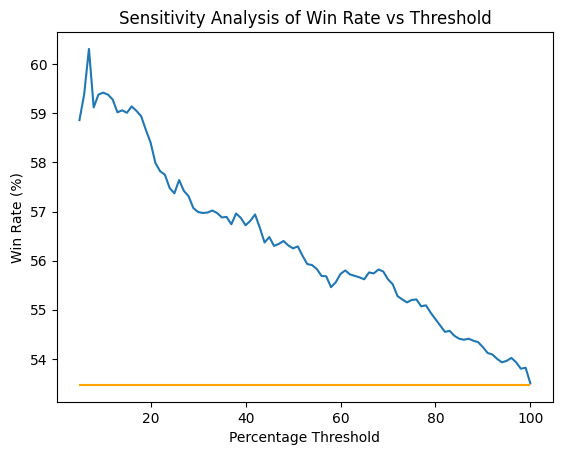

In [27]:
def simulate(price, threshold):
    price['Long'] = price.Pct < threshold
    price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.Return, 1.0)
    sys_win = price.Sys_Ret[price.Sys_Ret > 1.0].count()
    sys_loss = price.Sys_Ret[price.Sys_Ret < 1.0].count()
    sys_winrate = round(sys_win / (sys_win + sys_loss) * 100, 2)

    return sys_winrate

results = []
pct_range = range(5, 101)

for pct in pct_range:
    results.append(simulate(price, pct))

plt.plot(pct_range, results)
plt.hlines(bench_winrate, pct_range[0], pct_range[-1], colors = 'orange')
plt.title('Sensitivity Analysis of Win Rate vs Threshold')
plt.xlabel('Percentage Threshold')
plt.ylabel('Win Rate (%)')
plt.show()
    

What we're seeing here is the result of the strategy. We can see the winrates of the strategy, on the blue line, compared to the "buy and hold" strategy on the blue line. 

### Backtesting

Backtest rules:

1. Check if today's close is in the bottom n % of the day's range
2. If condition is met then enter on the close and exit the next day's close, unless the signal is repeated.

In [28]:
#drop redundant columns
#identify entries and allocate trading fees
STARTING_BALANCE = 10000
price['Long'] = np.logical_and((price.Pct < PCT_THRESH), (price.Range > 10))
#calculate system return and balance
price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.Return, 1)
price['Sys_Bal'] = (STARTING_BALANCE * price.Sys_Ret.cumprod())
#calculate benchmark return and balance
price['Return'] = price.Close / price.Close.shift(1)
price.Return.iat[0] = 1
price['Bench_Bal'] = STARTING_BALANCE * price.Return.cumprod()

price.tail()

,Open,High,Low,Close,Return,Range,Dist,Pct,Long,Sys_Ret,Sys_Bal,Bench_Bal
Date,,,,,,,,,,,,
2023-12-22,4753.919922,4772.939941,4736.770020,4754.629883,1.001660,36.169922,17.859863,49.377666,False,1.000000,60316.607377,32672.929032
2023-12-26,4758.859863,4784.720215,4758.450195,4774.750000,1.004232,26.270020,16.299805,62.047174,False,1.000000,60316.607377,32811.190721
2023-12-27,4773.450195,4785.390137,4768.899902,4781.580078,1.001430,16.490234,12.680176,76.895061,False,1.000000,60316.607377,32858.125743
2023-12-28,4786.439941,4793.299805,4780.979980,4783.350098,1.000370,12.319824,2.370117,19.238239,True,1.000000,60316.607377,32870.288987
2023-12-29,4782.879883,4788.430176,4751.990234,4769.830078,0.997174,36.439941,17.839844,48.956840,False,0.997174,60146.123993,32777.381936


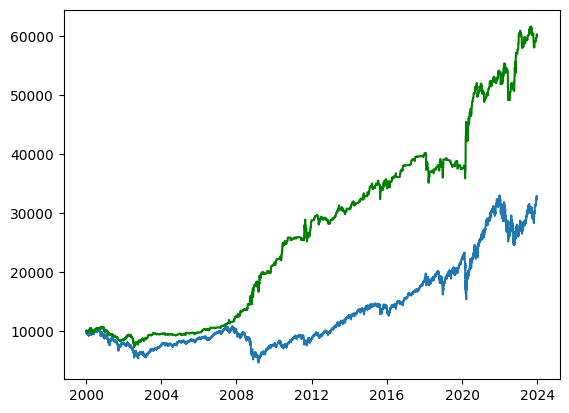

In [31]:
#plot balance
plt.plot(price.Bench_Bal)
plt.plot(price.Sys_Bal, color="g")
plt.show()

In [33]:
price['Bench_Peak'] = price.Bench_Bal.cummax()
price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak

bench_dd = round(((price.Bench_DD / price.Bench_Peak).min() * 100), 2)

#calculate system drawdown
price['Sys_Peak'] = price.Sys_Bal.cummax()
price['Sys_DD'] = price.Sys_Bal - price.Sys_Peak

sys_dd = round(((price.Sys_DD / price.Sys_Peak).min()) * 100, 2)

sys_dd

bench_dd
bench_return = round(((price.Bench_Bal.iloc[-1]/price.Bench_Bal.iloc[0]) - 1) * 100, 2)
bench_cagr = round(((((price.Bench_Bal.iloc[-1]/price.Bench_Bal.iloc[0])**(1/YEARS))-1)*100), 2)
sys_return = round(((price.Sys_Bal.iloc[-1]/price.Sys_Bal.iloc[0]) - 1) * 100, 2)
sys_cagr = round(((((price.Sys_Bal.iloc[-1]/price.Sys_Bal.iloc[0])**(1/YEARS))-1)*100), 2)
sys_in_market = round((price.Long.value_counts().loc[True] / len(price)) * 100)
sys_win = price.Sys_Ret[price.Sys_Ret > 1.0].count()
sys_loss = price.Sys_Ret[price.Sys_Ret < 1.0].count()
sys_winrate = round(sys_win / (sys_win + sys_loss) * 100, 2)

print(f'Benchmark Total return: {bench_return}%')
print(f'Benchmark CAGR: {bench_cagr}')
print(f'Benchmark DD: {bench_dd}%')
print('')
print(f'System Total return: {sys_return}%')
print(f'System CAGR: {sys_cagr}')
print(f'System DD: {sys_dd}%')
print(f'Time in Market: {sys_in_market}%')
print(f'Trades Won: {sys_win}')
print(f'Trades Loss: {sys_loss}')
print(f'Winrate: {sys_winrate}%')

Benchmark Total return: 227.77%
Benchmark CAGR: 5.07
Benchmark DD: -56.78%

System Total return: 501.46%
System CAGR: 7.76
System DD: -32.29%
Time in Market: 19%
Trades Won: 677
Trades Loss: 489
Winrate: 58.06%


In [34]:
#define list of ETFs to backtest
symbols = ['^GSPC', '^DJI', '^IXIC', '^RUT', '^N225']
def backtest(s):
    #download data
    price = yf.download(s, start=START, end=END)
    
    #drop redundant columns
    price = price.drop(['Volume', 'Adj Close'], axis=1)
    
    #calculate benchmark return and balance
    price['Return'] = price.Close / price.Close.shift(1)
    price.Return.iat[0] = 1
    price['Bench_Bal'] = STARTING_BALANCE * price.Return.cumprod()
    
    #calculate benchmark drawdown
    price['Bench_Peak'] = price.Bench_Bal.cummax()
    price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak
    
    #calculate additional columns for strategy
    #daily range
    price['Range'] = price.High - price.Low
    #distance between close and daily low
    price['Dist'] = abs(price.Close - price.Low)
    #distance as % of range
    price['Pct'] = (price.Dist / price.Range) * 100
    
    #identify entries and allocate trading fees
    price['Long'] = np.logical_and((price.Pct < PCT_THRESH), (price.Range > 10))
    
    #calculate system return and balance
    price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.Return, 1)
    price['Sys_Bal'] = (STARTING_BALANCE * price.Sys_Ret.cumprod())
    
    #calculate system drawdown
    price['Sys_Peak'] = price.Sys_Bal.cummax()
    price['Sys_DD'] = price.Sys_Bal - price.Sys_Peak
    
    #calculate metrics
    bench_cagr = round(((((price.Bench_Bal.iloc[-1]/price.Bench_Bal.iloc[0])**(1/YEARS))-1)*100), 2)
    bench_dd = round((price.Bench_DD / price.Bench_Peak).min() * 100, 2)
    sys_cagr = round(((((price.Sys_Bal.iloc[-1]/price.Sys_Bal.iloc[0])**(1/YEARS))-1)*100), 2)
    sys_dd = round(((price.Sys_DD / price.Sys_Peak).min()) * 100, 2)
    
    return bench_cagr, sys_cagr
#backtest multiple symbols
bc = []
sc = []

for symbol in symbols:
    bench_cagr, sys_cagr = backtest(symbol)
    bc.append(bench_cagr)
    sc.append(sys_cagr)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


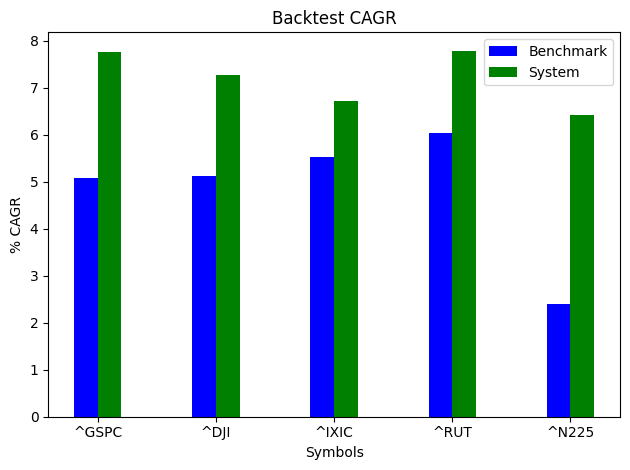

In [36]:
#plot data
x_indices = np.arange(len(symbols))
width = 0.2

plt.bar(x_indices - width / 2, bc, width = width, label = 'Benchmark', color="blue")
plt.bar(x_indices + width / 2, sc, width = width, label = 'System', color="green")
   
plt.xticks(ticks = x_indices, labels = symbols)

plt.legend()

plt.title('Backtest CAGR')
plt.xlabel('Symbols')
plt.ylabel('% CAGR')
plt.tight_layout()

plt.show()

Looks like another win for buying the dip. We can effectively conclude that it is still viable.